In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 湖北資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-湖北1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-湖北2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-湖北3.xls')
patent_df = pd.concat([df1,df2,df3],ignore_index=True)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'42\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
patent_df_firm

,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,申请人,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,发明人,IPC,CPC,简单同族,扩展同族,inpadoc同族,同族国家,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别
132621,12622,一种矿用巷道密闭横穿装置,5,3,到incoPat中查看\r\nCN201137502Y,CN201137502Y,2008-10-22,CN200820001472.9,2008-01-06,襄樊康晨机电工程有限公司,[晋煤集团-c],中国,湖北; 42,[襄阳],[襄樊],湖北省襄樊市高新技术开发区汽车工业园12号路,企业,CN200820001472 20080106,2,实用新型,姜铁明; 鞠盛文; 杜安东; 张勇; 王军; 孙勇建,E21F5/00; B05B7/04,NaN,CN201137502Y,CN201137502Y,CN201137502Y,CN,1,1,1,NaN,NaN,0,NaN,36.0,NaN,2011-01-06,CN
131881,11882,轻质保温墙体加强筋结构,5,3,到incoPat中查看\r\nCN201155169Y,CN201155169Y,2008-11-26,CN200820065255.6,2008-01-09,宜昌汇中环境工程有限责任公司,NaN,中国,湖北; 42,[宜昌],[西陵],湖北省宜昌市经济技术开发区青岛路,企业,CN200820065255 20080109,2,实用新型,朱洪; 王凯; 朱英俊; 李海涛,E04C5/00; E04B2/00,NaN,CN201155169Y,CN201155169Y,CN201155169Y,CN,1,1,1,NaN,NaN,0,NaN,0.0,NaN,2008-01-09,CN
130798,10799,一种基于无线传感技术的输变电在线监测装置,11,9,到incoPat中查看\r\nCN201185036Y,CN201185036Y,2009-01-21,CN200820065281.9,2008-01-10,武汉慧测科技有限公司,[国家电网-C],中国,湖北; 42,[武汉],[洪山],湖北省武汉市东湖开发区武黄公路189号华乐花园9－3－502,企业,CN200820065281 20080110,10,实用新型,魏万水; 方定江; 王世辉; 付斌; 张伟; 王家礼; 徐葵; 李振柱; 刘溟; 郑德龙; 邹建明; 张崇飞; 祁利; 魏立雄; 汤文华,G08C17/00; G08C23/06; G01R31/00; G01D21/02,NaN,CN201185036Y,CN201185036Y,CN201185036Y,CN,1,1,1,NaN,CN101859482B; CN101859482A; US8718979B2; CN102508005A; CN105092057A; CN103364029A; CN103148890A; CN103179695A; CN102759413A; CN105334427A,10,NaN,120.0,"中国, 美国",2018-01-10,CN
131178,11179,压纹复合地板,7,5,到incoPat中查看\r\nCN201172945Y,CN201172945Y,2008-12-31,CN200820065273.4,2008-01-10,武汉镭铭木业有限公司,NaN,中国,湖北; 42,[武汉],[东西湖],湖北省武汉市东西湖区欧亚达工业园8号,企业,CN200820065273 20080110,5,实用新型,金西茂,E04F15/02,NaN,CN201172945Y,CN201172945Y,CN201172945Y,CN,1,1,1,NaN,CN102959164B; CN102959164A,2,NaN,25.0,中国,2010-02-10,CN
130601,10602,冶金铸造钢丝绳电动葫芦,12,8,到incoPat中查看\r\nCN201186858Y,CN201186858Y,2009-01-28,CN200820065308.4,2008-01-14,湖北银轮蒲起机械有限责任公司,NaN,中国,湖北; 42,[咸宁],[赤壁],湖北省赤壁市河北大道170号湖北银轮蒲起机械有限责任公司,企业,NaN,6,实用新型,张吉均; 马贤才; 廖绪新,B66C17/12; B66D5/08; B66D5/02,NaN,CN201186858Y,CN201186858Y,CN201186858Y,CN,1,1,1,NaN,CN103803437A; CN103523691A; CN104803314A; CN104192745A; CN105731256A; CN104828727A; CN106185620A; CN109231052A,8,NaN,96.0,中国,2016-01-14,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17953,17954,一种脱水装置,9,9,到incoPat中查看\r\nCN204380356U,CN204380356U,2015-06-10,CN201420872523.0,2014-12-31,襄阳航生石化环保设备有限公司,NaN,中国,湖北; 42,[襄阳],[襄樊],湖北省襄樊市襄阳市157信箱,企业,NaN,10,实用新型,张琰; 李晋楼; 郭守学; 姜燕; 张建军; 邓伟伟; 余磊,B01D29/11; B01D29/86,NaN,CN204380356U,CN204380356U,CN204380356U,CN,1,1,1,NaN,CN104436791B,1,NaN,0.0,中国,NaT,CN
15972,15973,一种3d服装打印系统,5,9,到incoPat中查看\r\nCN204505843U,CN204505843U,2015-07-29,CN201420864409.3,2014-12-31,武汉金运激光股份有限公司,[金运激光-C],中国,湖北; 42,[武汉],[江岸],湖北省武汉市江岸区石桥一路6号金运激光大厦,企业,NaN,4,实用新型,梁伟,B29C67/00; B33Y50/00,NaN,CN204505843U,CN204505843U,CN204505843U,CN,1,1,1,NaN,CN106903890A; CN104608380A; CN105235215A; CN107788602A; CN107791509A,5,NaN,NaN,中国,NaT,CN
21630,21631,用于自动演奏钢琴与商业CD进行同步演奏的装置,7,7,到incoPat中查看\r\nCN204288785U,CN204288785U,2015-04-22,CN201420861493.3,2014-12-31,宜昌金宝乐器制造有限公司,NaN,中国,湖北; 42,[宜昌],[西陵],湖北省宜昌市经济开发区珠海路1号,企业,NaN,6,实用新型,吴天延,G10H7/00,NaN,CN204288785U,CN204288785U,CN204288785U,CN,1,1,1,NaN,NaN,0,NaN,0.0,NaN,NaT,CN
17601,17602,分体组合式气路电磁阀系列线圈磁扼限位组装夹具,7,3,到incoPat中查看\r\nCN204397686U,CN204397686U,2015-06-17,CN201520000068.X,2015-01-01,十堰市正发汽车零部件有限公司,NaN,中国,湖北; 42,[十堰],NaN,湖北省十堰市东城技术开发区鸳鸯村二组,企业,NaN,1,实用新型,王振,B25B11/02,NaN,CN204397686U,CN204397686U,CN204397686U,CN,1,1,1,NaN,CN106670756A; CN106670756B,2,NaN,24.0,中国,2017-01-01,CN


In [8]:
firm_gd

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str
0,05000304X,宜昌瑞克纺织品有限公司,湖北省宜昌市枝江市仙女工业园仙女一路,420583105001,1756,420583
1,05000857X,大悟新兴建材有限责任公司,湖北省孝感市大悟县东新乡东新街,420922202208,3121,420922
2,05002107X,赤壁市裕隆钙业有限责任公司,湖北省咸宁市赤壁市蓼坪村,421281101201,3124,421281
3,05003775X,黄梅依美制衣有限公司,湖北省黄冈市黄梅县蔡山镇江湖大道8号,421127108201,1810,421127
4,05262240X,随州市三庆水性印刷材料有限公司,湖北省随州市曾都区万店镇小河沟村,421303101206,2642,421303
...,...,...,...,...,...,...
11803,796344748,武汉华瑞电力科技股份有限公司,湖北省武汉市江夏区珞瑜路143号,420115086205,3939,420115
11804,796345054,武汉华夏玻璃制品有限公司常福分公司,湖北省武汉市蔡甸区星光,420114002204,3145,420114
11805,796345089,武汉普天电源有限公司,湖北省武汉市江夏区湛魏新村,420115086001,4011,420115
11806,796345505,武汉华源飞虹电气设备有限公司,湖北省武汉市黄陂区双凤大道(血防旁),420116001006,3922,420116


In [12]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [13]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\湖北_廠商.xlsx')

# 非模糊比對

In [14]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)

In [15]:
merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape

(2129, 45)

In [16]:
merge_df.shape

(17115, 45)

In [17]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [18]:
merge_df_clean[merge_df_clean['完整地址']==1].shape

(6411, 50)

In [19]:
merge_df_clean.shape

(12392, 50)

In [20]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\湖北_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(849, 44)
(13215, 44)
(3799, 49)
(13215, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\湖北_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', '序号', '标题', '文献页数', '合享价值度', '链接到incoPat', '公开（公告）号',
       '公开（公告）日', '申请号', '申请日', '申请人', '标准化申请人', '申请人国别代码', '申请人省市代码',
       '中国申请人地市', '中国申请人区县', '申请人地址', '申请人类型', '优先权信息', '权利要求数量', '专利类型',
       '发明人', 'IPC', 'CPC', '简单同族', '扩展同族', 'inpadoc同族', '同族国家', '简单同族个数',
       '扩展同族个数', 'inpadoc同族个数', '引证专利', '被引证专利', '被引证次数', '引证科技文献', '专利寿命（月）',
       '被引证国别(forward)', '失效日', '公开国别', 'name', 'address', '完整地址', 'lat',
       'lnt', '武漢東湖', '襄陽', '宜昌', '孝感', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','武漢東湖','襄陽','宜昌','孝感','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(4200, 56)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\湖北_結果.xlsx')

# 模糊比對

In [21]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)

In [22]:
merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape

(2320, 45)

In [23]:
merge_df_fuzzy.shape

(16862, 45)

In [24]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape

(6331, 50)

In [26]:
merge_df_fuzzy_clean.shape

(12224, 50)

In [27]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\湖北_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\湖北_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\湖北_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(4200, 56)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(13219, 56)
(135, 56)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\湖北_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
顺企业有限公司         1
梁黎明              1
梁鹏翔              1
梁鹏程              1
梁鹏               1
              ... 
东风汽车公司        1784
武汉理工大学        3713
武汉大学          4645
武汉钢铁(集团)公司    5358
华中科技大学        5809
Name: 專利數, Length: 50071, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\湖北_結果.xlsx',index_col=0)
target1 = (30.51435,114.38584)
merge_df['武漢東湖'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (32.05435,112.14111)
merge_df['襄陽'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (30.70086,111.31807)
merge_df['宜昌'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (30.92509,113.92405)
merge_df['孝感'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\湖北_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (30.51435,114.38584)
target2 = (32.05435,112.14111)
target3 = (30.70086,111.31807)
target4 = (30.92509,113.92405)

for i in merge_df[merge_df['武漢東湖']==''].index:
    merge_df.loc[i,'武漢東湖'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'襄陽'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'宜昌'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'孝感'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['武漢東湖']<10)or(x['襄陽']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['宜昌']<10)or(x['孝感']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\湖北_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(13219, 56)
0.7117785006430138
0.005749300249640669


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       9409
1.0        667
2.0        429
3.0        311
4.0        216
5.0        182
6.0        269
7.0        254
8.0        187
9.0        132
10.0       120
11.0        80
12.0       104
13.0        78
14.0        66
15.0        59
16.0        39
17.0        42
18.0        47
19.0        34
20.0        23
21.0        30
22.0        21
23.0        11
24.0        16
25.0        11
26.0        18
27.0        20
28.0        16
29.0        13
30.0        13
31.0        14
32.0        10
33.0        16
34.0         6
35.0         6
36.0        12
37.0        10
38.0         1
39.0         3
40.0         8
41.0         4
42.0         7
43.0         4
44.0         6
45.0         6
46.0         5
47.0         3
48.0         2
49.0         4
50.0         9
51.0         7
52.0         7
54.0         2
55.0         5
56.0         3
57.0         3
58.0         1
59.0         5
60.0         2
61.0         1
63.0         1
64.0         4
66.0         2
67.0         4
68.0         4
69.0  

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     113
1.0       4
2.0       2
3.0       1
4.0       1
5.0       3
6.0       1
9.0       3
10.0      1
11.0      1
12.0      1
15.0      1
16.0      1
20.0      1
23.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

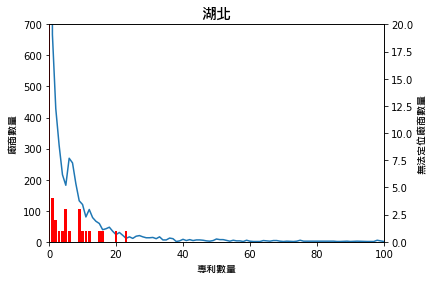

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('湖北',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,700])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\湖北_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

1331
0.10255027351876107
37


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1      310
2      190
3      127
4       93
5       53
6       53
7       67
8       47
9       41
10      37
11      20
12      27
13      20
14      14
15      19
16       8
17      18
18      16
19      10
20       8
21       3
22       5
23       3
24       4
25       3
26       7
27       1
28       6
29       3
30       5
31       6
32       2
33       5
34       1
35       2
36       2
37       6
40       2
41       2
42       2
44       3
45       1
46       2
47       2
49       3
50       4
51       1
52       3
55       2
56       1
59       3
60       1
62       1
66       1
68       1
69       1
71       1
74       1
75       1
76       1
80       1
81       2
82       1
85       2
88       1
89       1
90       1
92       1
95       1
98       1
104      1
105      1
107      1
112      1
115      1
117      1
121      1
125      1
129      1
132      1
146      2
147      1
156      1
162      1
167      1
176      1
184      1
193      1
195      1
200      1
204   

In [4]:
not_merge[not_merge['專利數']>=400].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,...,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别,申请人,name,address,完整地址,lat,lnt,武漢東湖,襄陽,宜昌,孝感,早期園區,近期園區,專利數,name_clean
12846,,,,,,,17779,一种智能平衡悬架系统,8,9,到incoPat中查看\r\nCN102950984B,CN102950984B,2015-06-10 00:00:00,CN201210437820.8,2012-11-06 00:00:00,[东风汽车-C],中国,湖北; 42,[十堰],[张湾],湖北省十堰市张湾区车城西路2号,企业,,5,发明授权,...,2,7,3,US5522469A; CN1984789A; CN202896205U; CN201745405U; US20090072505A1; JP10166825A; CN101830254A; CN201863674U; DE29612129U1; JP3619482B2; CN201099156Y; CN2832570Y,,0,,,,,CN,东风商用车有限公司,东风商用车有限公司,湖北省十堰市张湾区车城西路2号,1,30.5094,114.173,20.421410,258.414017,274.605024,51.897664,0,0,406,东风商用车
13025,,,,,,,11730,基于GSM-R实现的列车自动驾驶车地通信系统及方法,9,9,到incoPat中查看\r\nCN103237044B,CN103237044B,2016-01-20 00:00:00,CN201210593333.0,2012-12-31 00:00:00,[中国铁建-C],中国,湖北; 42,[武汉],[武昌],湖北省武汉市武昌区杨园和平大道745号铁四院技术中心,企业,,7,发明授权,...,2,2,2,CN203014867U; CN102267481A; CN101007537A; CN102233887A; JP2004080838A; CN101117128A,,0,,0,,,CN,中铁第四勘察设计院集团有限公司,中铁第四勘察设计院集团有限公司,湖北省武汉市武昌区杨园和平大道745号铁四院技术中心,1,30.6024,114.346,10.490760,264.454210,290.392697,53.940760,0,0,606,中铁第四勘察设计院
13010,,,,,,,22959,一种堆石坝砾石土心墙底部的填筑方法,6,9,到incoPat中查看\r\nCN103046516B,CN103046516B,2015-04-01 00:00:00,CN201210588184.9,2012-12-29 00:00:00,[葛洲坝-C],中国,湖北; 42,[宜昌],[西陵],湖北省宜昌市清波路1号,企业,,8,发明授权,...,2,2,2,CN101476309A; CN101538839A; US20100284747A1,,0,,0,,,CN,中国葛洲坝集团股份有限公司,中国葛洲坝集团股份有限公司,湖北省宜昌市清波路1号,1,30.7278,111.292,297.579365,167.800330,3.898654,252.778191,0,1,706,中国葛洲坝
12953,,,,,,,24319,地下连续墙超长钢筋笼整体吊装装置和方法,8,9,到incoPat中查看\r\nCN103043526B,CN103043526B,2015-03-11 00:00:00,CN201210550120.X,2012-12-17 00:00:00,[中冶集团-C],中国,湖北; 42,[武汉],[青山],湖北省武汉市青山区工业大道3号,企业,,5,发明授权,...,2,2,2,US7444730B1; JP11005687A; JP07267570A; US20030205907A1; JP07101670A; JP2000289971A; CN102070071A; CN201240771Y; CN202400722U; CN203173681U; CN101225667A,,0,,,,,CN,中国一冶集团有限公司,中国一冶集团有限公司,湖北省武汉市青山区工业大道3号,1,30.627,114.388,12.488033,265.971130,294.276351,55.325492,0,0,737,中国一冶


Text(0.5, 0, '專利數量')

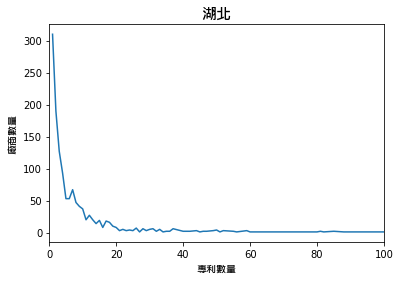

In [5]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('湖北',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [6]:
cleaned.to_excel(r'E:\paper\名稱merge\湖北_結果.xlsx')

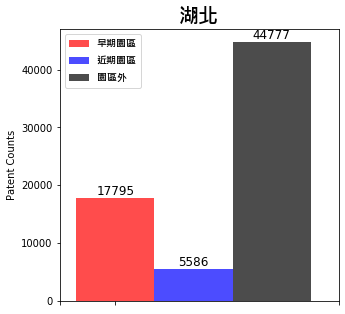

In [10]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('湖北',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

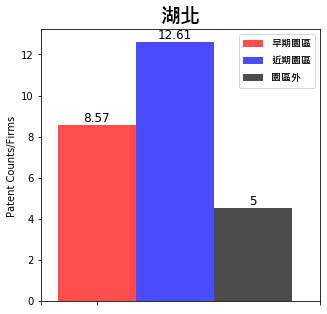

In [11]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('湖北',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)